In [1]:
import numpy as np
import sympy

#from ldpc import BpOsdDecoder
from bposd import css_decode_sim

from autqec.automorphisms import *
from autqec.utils.qec import *
from autqec.utils.qiskit import *
from autqec.magma_interface import *
from autqec.ZX_dualities import *
from autqec.ZY_dualities import *
import pickle

# Constructing BB5 codes

## Construction of parity check matrices

In [2]:
def circulant_matrix(l):

    """Defines an l x l circulant matrix where the first row is of the form (0 1 0 ... 0)
    
    Input: l (int): the dimensions of the circulant matrix
    
    Output: Q (np array): the l x l circulant matrix 
    
    """

    if not l.is_integer():
        print("l must be an integer")
        return

    Q = np.identity(l).astype(int)

    first = Q[0]

    Q = np.delete(Q, 0, 0)
    Q = np.append(Q,[first], axis=0)

    return Q

In [3]:
def construct_A(l, m, u, v):
    """ Constructs an A block component of the parity check matrices of a BB code

    Input: 
        l (int) : dimenions of first circulant matrix

        m (int) : dimensions of second circulant matrix

        u (int) : power of first circulant matrix

        v (int) : power of second circulant matrix

    Output:   
    
        The kronecker product of (Q_l)^u and (Q_m)^v
    """

    if not l.is_integer() or not m.is_integer() or not u.is_integer() or not v.is_integer():
        print("All parameters must be integers")
        return
    
    if u >= l or v >= m:
        print("l must be greater than u and m must be greater than v")
        return
    

    Q_l = circulant_matrix(l)
    Q_m = circulant_matrix(m)

    if u == 0:
        Q_l_u = np.identity(l).astype(int)
    else:
        Q_l_u = Q_l


    for i in range(u-1):
        Q_l_u = np.matmul(Q_l_u, Q_l_u)
    
    if v == 0:
        Q_m_v = np.identity(m).astype(int)
    else:
        Q_m_v = Q_m

    for i in range(v-1):
        Q_m_v = np.matmul(Q_m_v, Q_m_v)

    return np.kron(Q_l_u, Q_m_v)
    

In [4]:
def generate_pcms(A1, A2, A3, A4, A5):
    Hx = np.hstack(( A1+A2, A3 + A4+A5))
    Hz = np.hstack((np.transpose(A3) + np.transpose(A4) + np.transpose(A5), np.transpose(A1) + np.transpose(A2)))

    return Hx, Hz
                   

In [5]:
l = 8
m = 3

A1 = construct_A(l, m, 0, 0)
A2 = construct_A(l, m, 1, 0)
A3 = construct_A(l, m, 0, 0)
A4 = construct_A(l, m, 0, 1)
A5 = construct_A(l, m, 3, 2)

Hx, Hz = generate_pcms(A1, A2, A3, A4, A5)

## Checking their parameters and performance

In [6]:
osd_options={
#'target_runs': 100000,
'xyz_error_bias': [1, 1, 1],
'bp_method': "minimum_sum", 
'ms_scaling_factor': 0.05,
'osd_method': "osd_cs",
'osd_order': 4,
'channel_update': None, 
'seed': 42,
'max_iter': 9, 
#'output_file': "test.json"
'error_bar_precision_cutoff': 1e-6
}

In [32]:
p = 0.01
bb5 = css_decode_sim.css_decode_sim(hx = Hx, hz = Hz, error_rate = p, target_runs = 1000, **osd_options) #bposd decoder (to find the dist)

RNG Seed: 42
Constructing CSS code from hx and hz matrices...
Checking the CSS code is valid...
<Unnamed CSS code>
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params [48,4,nan]


d_max: 4; OSDW_WER: 0.0751±0.043%; OSDW: 0.3±0.17%; OSD0: 0.4±0.2%;: 100% 1000/1000 [00:00<00:00, 2633.76it/s]    


# Use autqec to compute automorphisms and logicals

In [12]:
H_symp  = np.hstack((Hx, Hz))
n = 48
k = 4
d = 4

In [14]:
#make find only the linearly independent stabilizer generators

_, inds = sympy.Matrix(H_symp).T.rref()
inds
H_symp = H_symp[inds, :]

In [200]:
import autqec.utils.linalg  

In [15]:
_, pivots, _, _ = rref_mod2(H_symp.T)
print(pivots)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [16]:
H_symp = H_symp[pivots, :] #cuts out rows that are linearly dependent on other rows to make H_symp full rank

In [17]:
print(rank_mod2(H_symp)) #double check that
print(len(H_symp))

22
22


In [18]:
code_auts_dict = qec_code_auts_from_magma_with_intersection(n,k,d,H_symp).run(fileroot="/Users/rebeccaradebold/Desktop/logical_operators/",save_magma_commands = True)

print('Aut Group Order: ', code_auts_dict['order'])
print('Time: ', code_auts_dict['time'])
print('No of aut gens: ', len(code_auts_dict['auts']))

Run the commands on MAGMA online calculator.
Copy and save output as 'magma_output_n48k4d4.txt'

Aut Group Order:  2
Time:  0.0
No of aut gens:  3


In [19]:
print(code_auts_dict['auts'])

[[(np.int64(3), np.int64(99)), (np.int64(6), np.int64(96)), (np.int64(9), np.int64(93)), (np.int64(12), np.int64(90)), (np.int64(15), np.int64(87)), (np.int64(18), np.int64(84)), (np.int64(21), np.int64(81)), (np.int64(24), np.int64(78)), (np.int64(27), np.int64(75)), (np.int64(30), np.int64(144)), (np.int64(33), np.int64(141)), (np.int64(36), np.int64(138)), (np.int64(39), np.int64(135)), (np.int64(42), np.int64(132)), (np.int64(45), np.int64(129)), (np.int64(48), np.int64(126)), (np.int64(51), np.int64(123)), (np.int64(54), np.int64(120)), (np.int64(57), np.int64(117)), (np.int64(60), np.int64(114)), (np.int64(63), np.int64(111)), (np.int64(66), np.int64(108)), (np.int64(69), np.int64(105)), (np.int64(72), np.int64(102)), (np.int64(2), np.int64(97)), (np.int64(5), np.int64(94)), (np.int64(8), np.int64(91)), (np.int64(11), np.int64(88)), (np.int64(14), np.int64(85)), (np.int64(17), np.int64(82)), (np.int64(20), np.int64(79)), (np.int64(23), np.int64(76)), (np.int64(26), np.int64(73)),

In [20]:
auts = code_auts_dict['auts']
circuits = []
symp_mats = []
for num, aut in enumerate(auts):
    phys_act = circ_from_aut(H_symp,aut)        
    phys_circ, _ = phys_act.circ()
    log_act = logical_circ_and_pauli_correct(H_symp,phys_circ)
    circ = log_act.run()
    circuits.append(circ)
    symp_mats.append(log_act.U_logical_act())

In [ ]:
filename = f'"/Users/rebeccaradebold/Desktop/logical_operators/symp_mats_n{n}k{k}d{d}.pkl'
with open(filename, 'wb') as f:
    pickle.dump(symp_mats, f)

In [21]:
circ = circuits[0]

print(circ[1])

[('Z', 1), ('Z', 2), ('Z', 4), ('Z', 5), ('Z', 7), ('Z', 8), ('Z', 10), ('Z', 11), ('Z', 13), ('Z', 14), ('Z', 16), ('Z', 17), ('Z', 19), ('Z', 20), ('Z', 24), ('X', 26), ('X', 27), ('X', 29), ('X', 30), ('X', 32), ('X', 33), ('X', 34), ('X', 38), ('X', 39), ('X', 41), ('X', 42), ('X', 44), ('X', 45), ('X', 47), ('X', 48), ('H', 1), ('H', 2), ('H', 3), ('H', 4), ('H', 5), ('H', 6), ('H', 7), ('H', 8), ('H', 9), ('H', 10), ('H', 11), ('H', 12), ('H', 13), ('H', 14), ('H', 15), ('H', 16), ('H', 17), ('H', 18), ('H', 19), ('H', 20), ('H', 21), ('H', 22), ('H', 23), ('H', 24), ('H', 25), ('H', 26), ('H', 27), ('H', 28), ('H', 29), ('H', 30), ('H', 31), ('H', 32), ('H', 33), ('H', 34), ('H', 35), ('H', 36), ('H', 37), ('H', 38), ('H', 39), ('H', 40), ('H', 41), ('H', 42), ('H', 43), ('H', 44), ('H', 45), ('H', 46), ('H', 47), ('H', 48), ('SWAP', (24, 34)), ('SWAP', (23, 35)), ('SWAP', (22, 36)), ('SWAP', (21, 37)), ('SWAP', (20, 38)), ('SWAP', (19, 39)), ('SWAP', (18, 40)), ('SWAP', (17, 41

Logical circuit on n qubits:


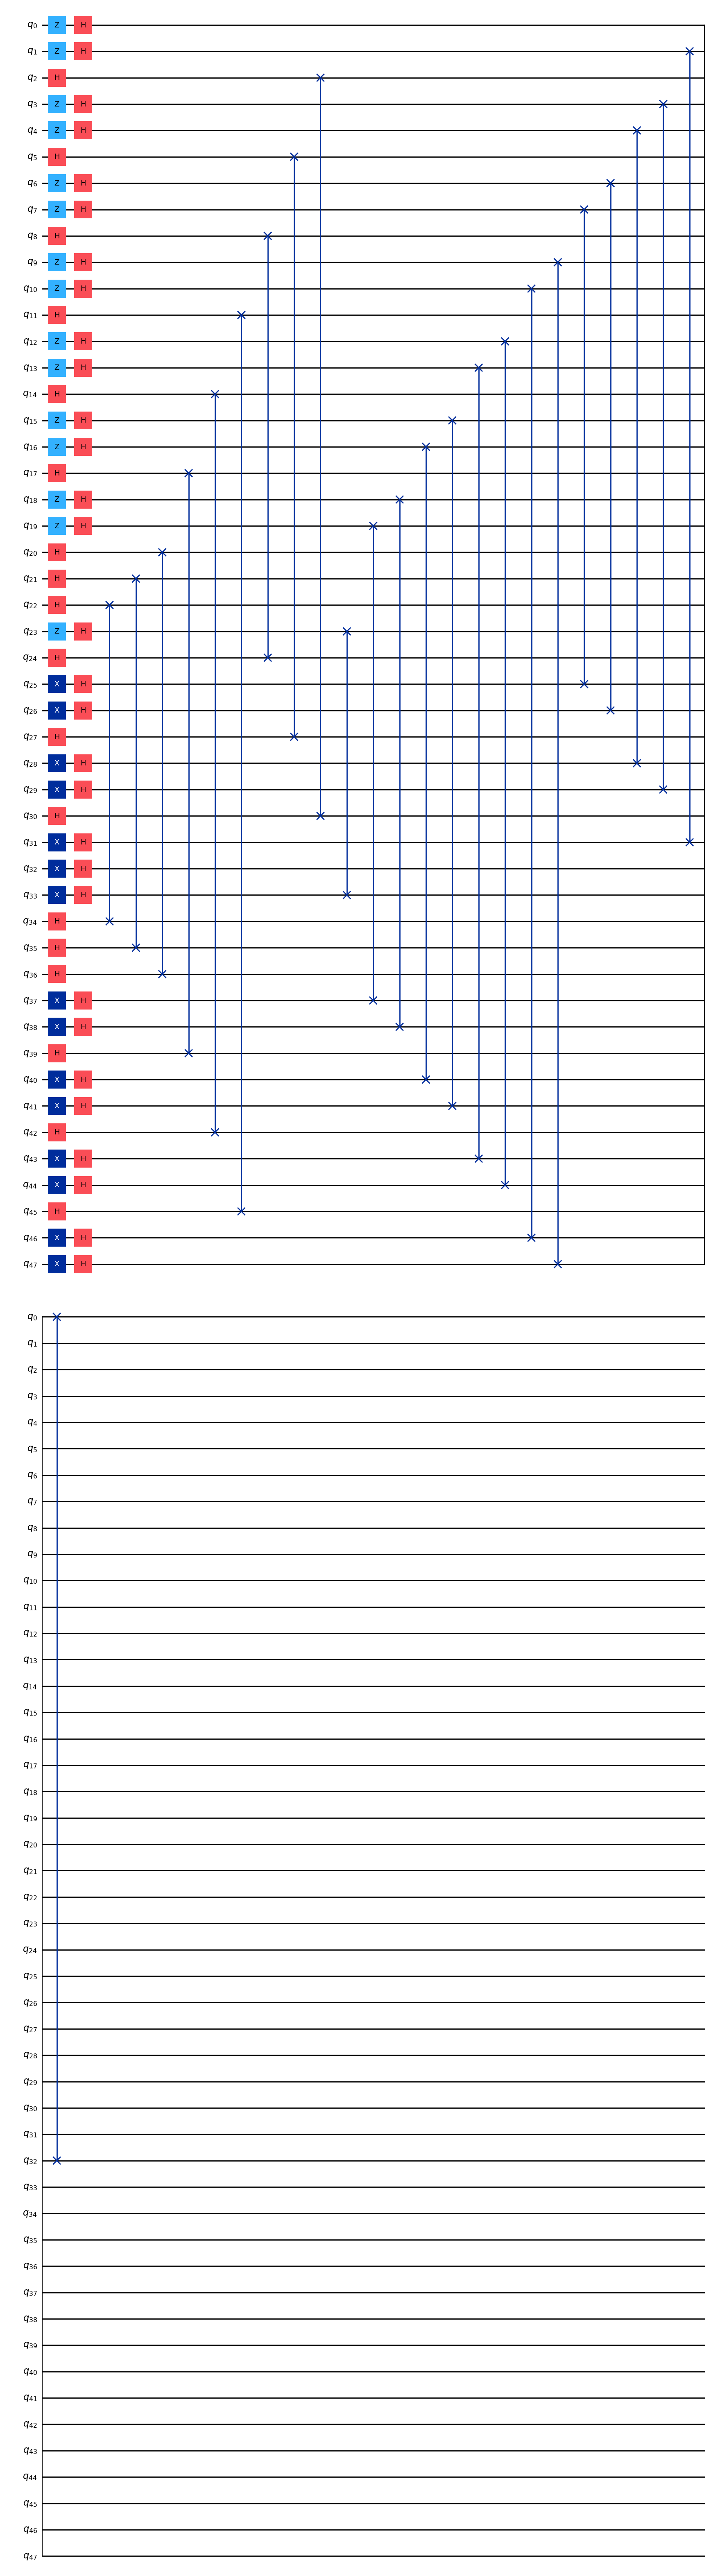

In [22]:
circ = circuits[0]
print('Logical circuit on n qubits:')
qc = construct_circuit(circ[1], n)
qc.draw(output='mpl')

Logical action on k qubits:


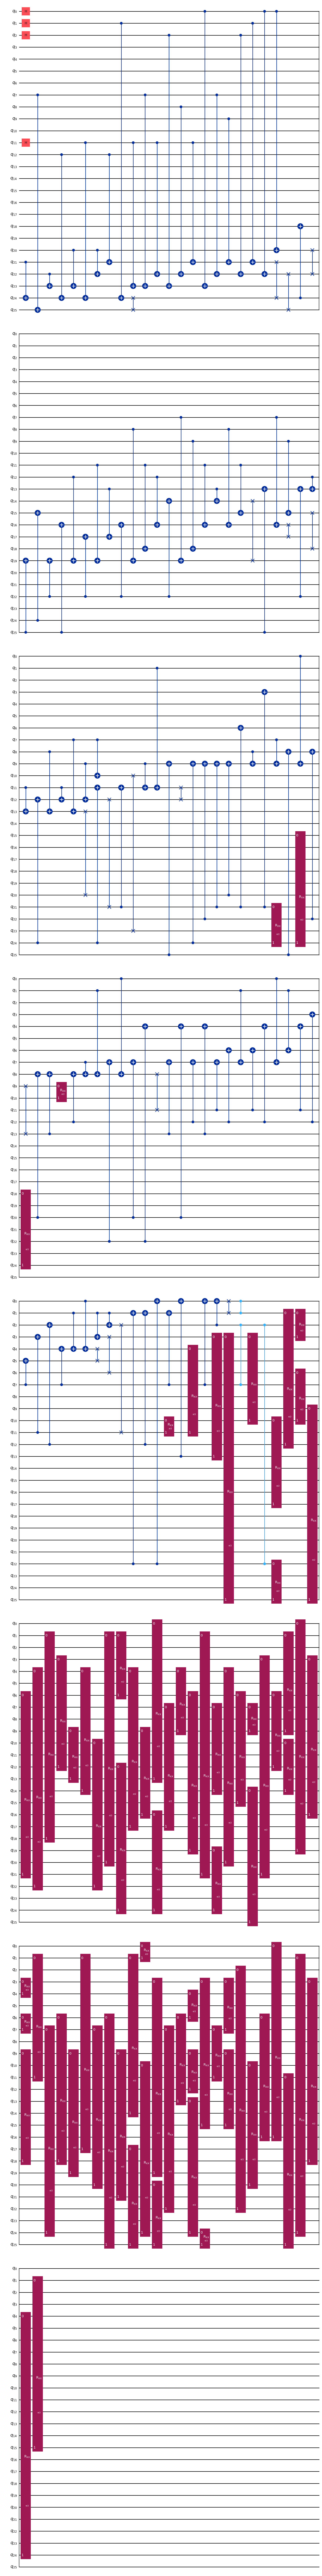

In [28]:
print('Logical action on k qubits:')
qc = construct_circuit(circ[0], 26)
qc.draw(output='mpl')